## Forecasting Energy Output with FB Prophet

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.metrics import mean_absolute_error, mean_squared_error
from fbprophet import Prophet

In [2]:
df = pd.read_csv('../data/interim/filled_for_forecasting.csv', index_col = 0, parse_dates = True)

In [3]:
df.columns

Index(['Shark Meter, KWtotal Kilowatts', 'AE 500kW 1, AC Power Kilowatts',
       'AE 500kW 2, AC Power Kilowatts',
       '(Offline) Weather Station - POA (POA)* Watts/meter²',
       'RECx31 Weather Station, Module Temp Degrees Celsius',
       'RECx31 Weather Station, Ambient Temp Degrees Celsius',
       'AE 500kW 1, PV current Amps', 'AE 500kW 2, PV current Amps',
       'AE 500kW 1, PV voltage Volts', 'AE 500kW 2, PV voltage Volts'],
      dtype='object')

This is our filled energy output.  One thing we'd like to do is see if we can forecast in 15-minute intervals since it seems that our H-W models and our Sarima models do not do that well.  Let's just take a two week slice of the data and see how Prophet does.  

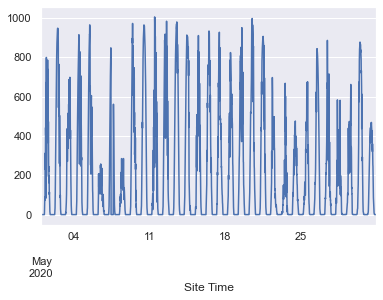

In [4]:
df['Shark Meter, KWtotal Kilowatts'].loc['2020-05'].plot();

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


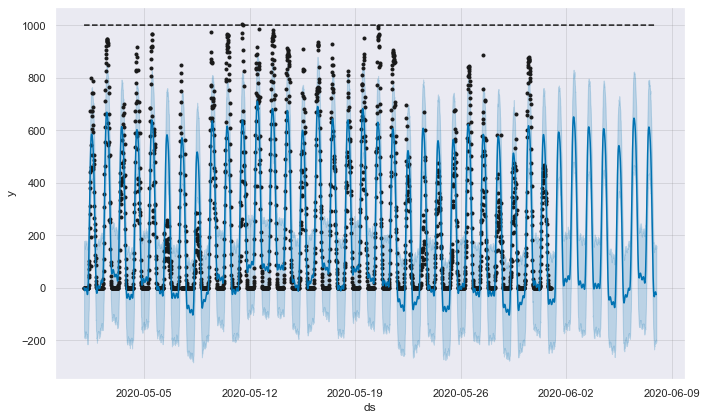

In [8]:
# Our dataframe must have columns 'ds' and 'y'
power_May2020 = df.loc['2020-05'].copy()
power_May2020['y'] = power_May2020['Shark Meter, KWtotal Kilowatts']
power_May2020['ds'] = power_May2020.index
power_May2020['cap'] = 1000.0
power_May2020['floor'] = 0.0

prophet = Prophet()
prophet.fit(power_May2020)
future = prophet.make_future_dataframe(periods=4*24*7, freq='15T')
future['cap']=1000.0
future['floor']=0.0
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
#a = add_changepoints_to_plot(fig.gca(), prophet, forecast)

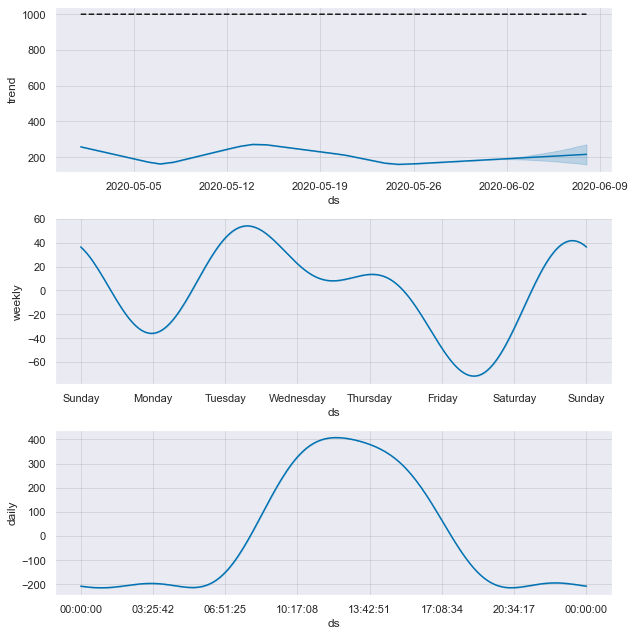

In [9]:
fig2 = prophet.plot_components(forecast)

The original data is the black dots, the forecast line is in blue, and the confidence levels are in light blue.  We can see that Prophet is doing quite well with this forecast.  Much better than H-W or SARIMA.  Note that sometimes it does predict negative energy output which is interesting.  

Let's get prediction of the trend.  To that end, let's look at energy, and we're going to resample to a daily frequency and then predict a trend over the next six years.  

In [10]:
# First we need to get hourly energy in KWH
energy_hourly = df[['Shark Meter, KWtotal Kilowatts']].resample('H').sum()*.25
energy_hourly.columns=['Shark Meter, KWH']

# Then we need to get daily energy in KHW
energy_daily = energy_hourly.resample('D').sum()

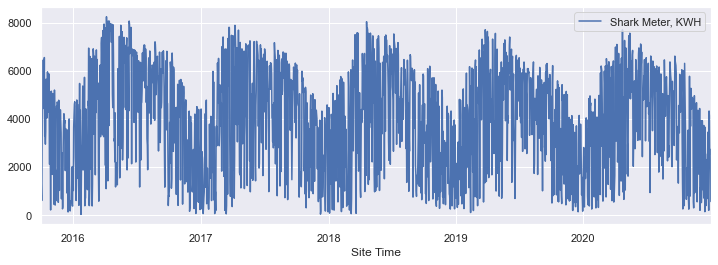

In [11]:
energy_daily.plot(figsize=(12,4));

This is so noisy.  Let's smooth it out by taking a rolling average.

In [12]:
energy_daily_rolling7D = energy_daily.rolling(window='7D').mean()

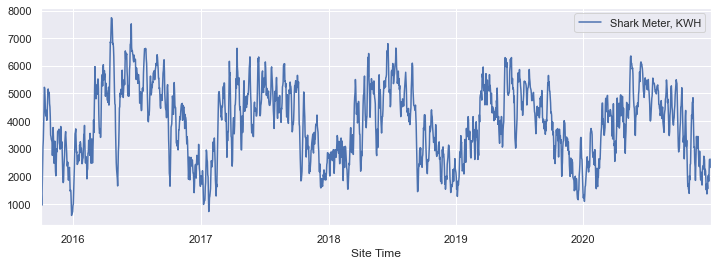

In [13]:
energy_daily_rolling7D.plot(figsize=(12,4));

In [14]:
energy_daily_rolling7D.shape

(1919, 1)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


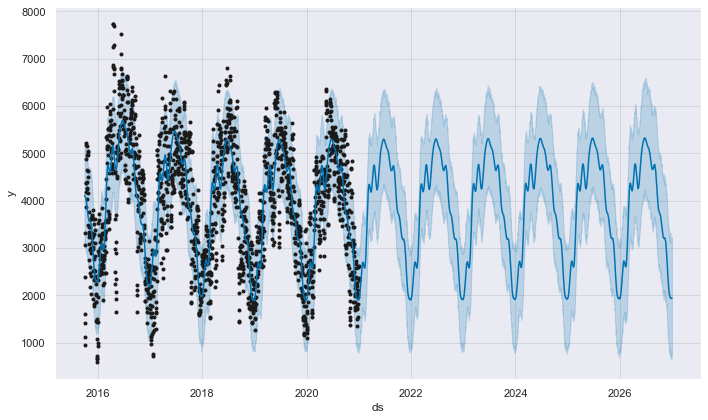

In [15]:
energy_daily_rolling7D['y'] = energy_daily_rolling7D['Shark Meter, KWH']
energy_daily_rolling7D['ds'] = energy_daily_rolling7D.index

prophet = Prophet()
prophet.fit(energy_daily_rolling7D)
future = prophet.make_future_dataframe(periods=365*6, freq='D')
forecast = prophet.predict(future)
fig = prophet.plot(forecast)

This is interesting. This is showing no downward trend over time, whereas our sesaonal decomposition definitely showed a downward trend.  

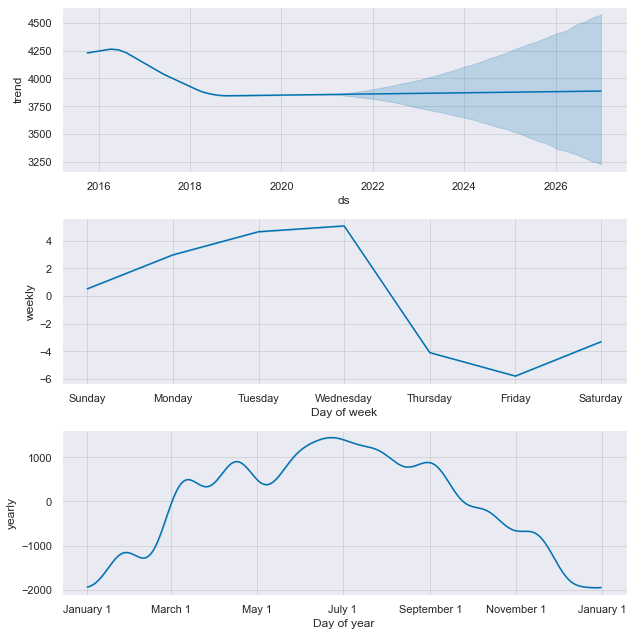

In [16]:
fig2 = prophet.plot_components(forecast)
plt.show()

So FB Prophet sees an initial downward trend but then sees it stabilize.  You can clearly see the yearly variation. 

### Attempt to forecast Difference between Inverters 

In [17]:
# First we need to get hourly energy in KWH
inverters_hourly = df[['AE 500kW 1, AC Power Kilowatts','AE 500kW 2, AC Power Kilowatts']].resample('H').sum()*.25
inverters_hourly.columns=['AE 500kW 1, KWH','AE 500kW 2, KWH']

# Then we need to get daily energy in KHW
inverters_daily = inverters_hourly.resample('D').sum()

# Now calculate the difference
inverters_diff = pd.DataFrame(inverters_daily['AE 500kW 1, KWH'] - inverters_daily['AE 500kW 2, KWH'],columns=['Difference'])

# Get max ambient and module temps
inverters_diff['Max Module Temp'] = df['RECx31 Weather Station, Module Temp Degrees Celsius'].resample('D').max()
inverters_diff['Max Ambient Temp'] = df['RECx31 Weather Station, Ambient Temp Degrees Celsius'].resample('D').max()
               

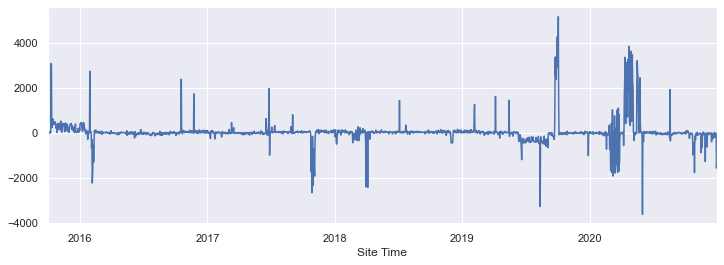

In [19]:
inverters_diff['Difference'].plot(figsize=(12,4));

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


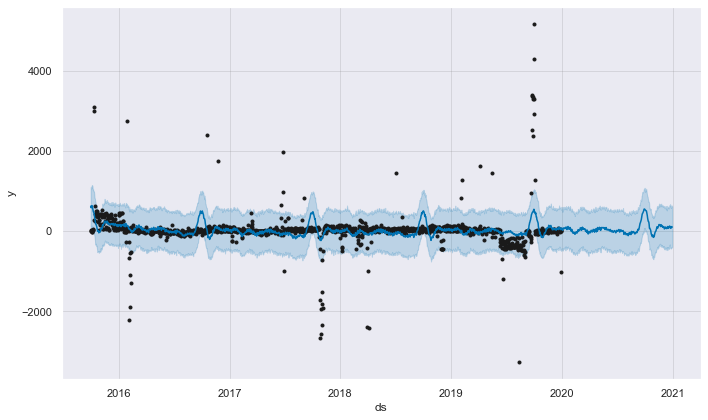

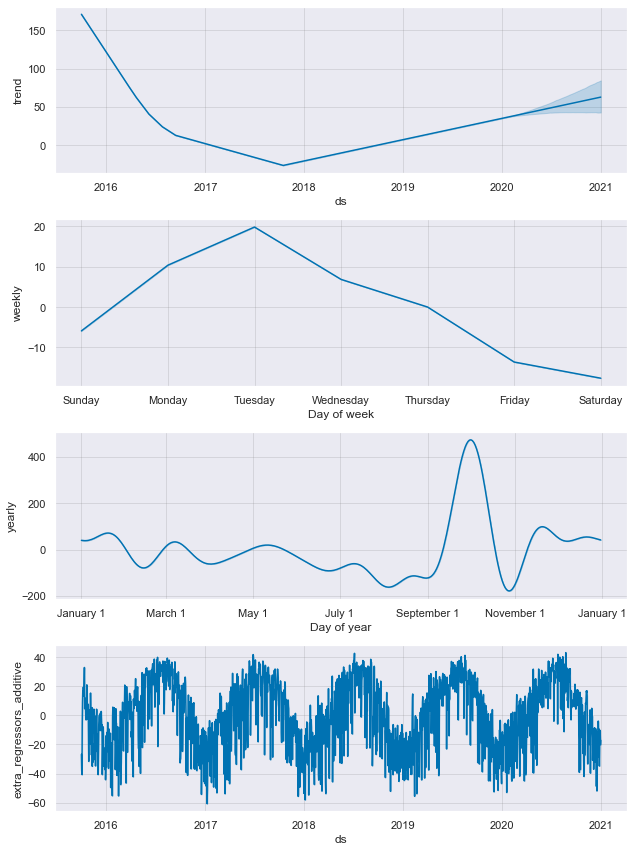

In [18]:
inverters_diff['y'] = inverters_diff['Difference']
inverters_diff['ds'] = inverters_diff.index

prophet = Prophet()
prophet.add_regressor('Max Module Temp')
prophet.add_regressor('Max Ambient Temp')
prophet.fit(inverters_diff.loc[:'2019'])
future = prophet.make_future_dataframe(periods=365, freq='D')
future.set_index('ds',inplace=True)
future['Max Module Temp'] = inverters_diff['Max Module Temp']
future['Max Ambient Temp'] = inverters_diff['Max Ambient Temp']
future.reset_index(inplace=True)
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
fig2 = prophet.plot_components(forecast)